In [1]:
import pandas as pd
import numpy as np
import cv2
import os
from matplotlib import pyplot as plt
import random
from sklearn.metrics import r2_score
import math
from sklearn.cluster import AgglomerativeClustering as ac
from scipy.cluster.hierarchy import dendrogram, linkage
import seaborn as sns
from sklearn.cluster import KMeans
import sys
import copy
np.set_printoptions(threshold=sys.maxsize)

In [2]:
#Sources
#https://medium.com/analytics-vidhya/color-separation-in-an-image-using-kmeans-clustering-using-python-f994fa398454

In [3]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images
#Presentation- 5 mins, 3 mins of questions; submit presentation on moodke prior
#Analysis ideas- see how CNN recognition performance decreases, see how human performance decreases

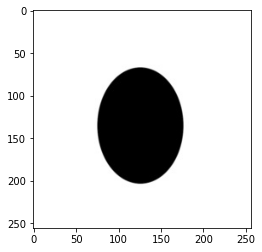

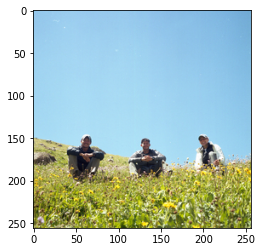

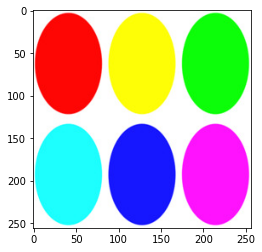

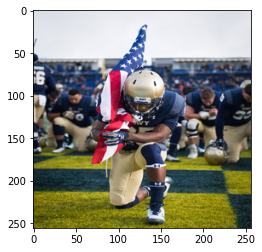

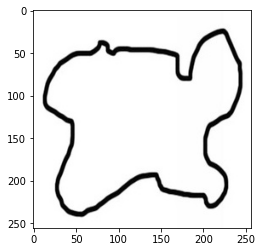

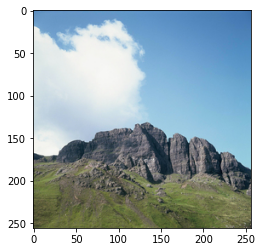

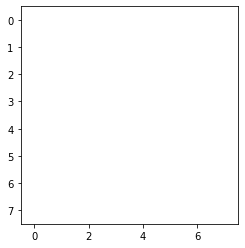

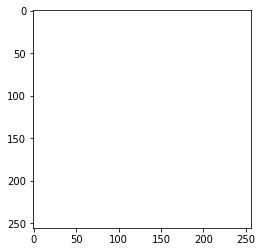

In [4]:
pics = np.zeros(shape=(7, 256, 256, 3))
pics = load_images_from_folder('pics')
for pic in pics:
    plt.imshow(pic[...,::-1])
    plt.show()

## Proof of Concept Steps based on Edge Detection

array([[129, 126, 116, 140, 109, 146, 104, 149, 101, 100, 150, 153, 154,
         97, 155, 156, 161,  89,  88, 164, 166,  85,  84,  83, 169, 168,
         81, 172, 173, 174,  76, 175,  75, 176,  77,  78,  80, 171,  82,
        165, 162,  90, 159,  91,  93, 158, 157,  96,  99, 147, 103, 107,
        143, 139, 137, 114, 121, 132],
       [ 67,  67,  68,  70,  70,  73,  74,  75,  75,  76,  76,  77,  78,
         79,  80,  80,  87,  88,  90,  91,  93,  95,  96,  97,  99,  99,
        104, 107, 110, 114, 119, 120, 131, 136, 155, 157, 164, 166, 169,
        177, 183, 184, 186, 186, 187, 187, 189, 190, 193, 197, 197, 199,
        200, 201, 202, 202, 203, 203]])

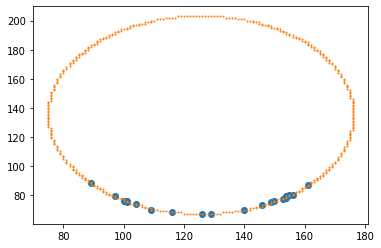

In [5]:
#Canny edge detection
img1 = pics[0].astype('uint8')
gray = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
gray = np.float32(gray)
edges = cv2.Canny(img1,100,200)
coord = np.array(np.where(edges != 0))
coord[[0, 1]] = coord[[1, 0]]
#plt.imshow(edges,cmap='gray')
#plt.show()
ind = random.sample(range(0, len(coord[0])), int(len(coord[0])/5))
points = (coord[0][ind], coord[1][ind])
points = np.array(points)
points = (points[0][np.argsort(points[1])], points[1][np.argsort(points[1])])
points = np.array(points)
plt.scatter(points[0][0:20], points[1][0:20])
plt.scatter(coord[0], coord[1], s=1)
oc_set = set() 
res = [] 
for idx, val in enumerate(points[0]): 
    if val not in oc_set: 
        oc_set.add(val)          
    else: 
        res.append(idx)
point = np.zeros(shape=(2,len(points[0])-len(res)))
point[0] = np.delete(points[0], res)
point[1] = np.delete(points[1], res)
coords = point.astype(int)
coords

0.9966549791294196


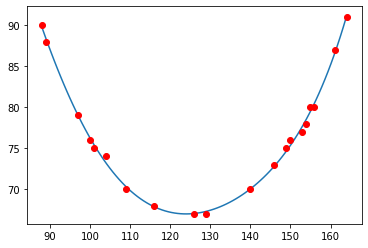

In [6]:
x = coords[0][0:20]
y = coords[1][0:20]
pol = np.poly1d(np.polyfit(x, y, 5))

xx = np.linspace(min(x),max(x), 100)
yy = np.polyval(pol,xx)  
pixels = zip(xx, yy)

plt.plot(xx, yy, '-',x, y, 'ro')
print(r2_score(y, pol(x)))

In [7]:
blank = pics[-1].copy()

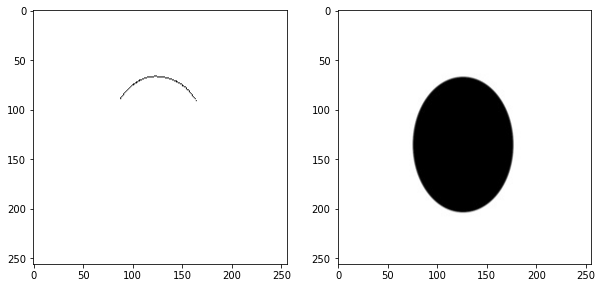

In [8]:
for x, y in pixels:
    blank[int(y)][int(x)][:] = 0
fig=plt.figure(figsize=(10, 10))
fig.add_subplot(1, 2, 1)
plt.imshow(blank[...,::-1])
fig.add_subplot(1, 2, 2)
plt.imshow(pics[0][...,::-1])
plt.show()

## Testing/Old funcs

In [9]:
"""
#Old method
r1 = -1
r2 = -1
reachable = False
for m in range(0,3):
    for n in range(0,3):
        if i == startX and j == startY:
            reachable = True
        if not(i+r1+m > img1.shape[0]-1 or i+r1+m < 0 or j+r2+n > img1.shape[0]-1 or j+r2+n < 0):
            if (imgClusters[i+r1+m][j+r2+n] == imgClusters[i][j] and visited[i+r1+m][j+r2+n] == 0):
                reachable = True

#Find Home Testing
startX = 0
startY = 0
i = 3
j = 3
imgClusters = np.ones((8,8)).astype(int)
searched = np.ones((8,8)).astype(int)
finds = []
imgClusters[3:6,3:6] = 1
visited = np.ones((8,8)).astype(int)
visited[0:2,0:8] = 0
visited[0:4,0:2] = 0
visited[2,7] = 0
visited[i,j] = 1
clusterNum = 1
cMean = [255,255,255]
findHome(startX, startY, i, j, img1, imgClusters, visited, clusterNum, cMean, finds)
print(2 in finds)
searched
"""
q=0

# Color Region Detection

## K Means for region detection

[581503375.0212628, 2701192.6683384506, 763988.508094401, 365752.06711732317, 220587.72664534242, 151298.55489676303, 107090.72010707611, 79019.28212360558, 64743.41261076186, 50952.750239579545, 41766.51227080583, 36255.38401736606, 30863.68983130621, 27694.84077801825, 23204.43418459064, 20534.349406044923, 16942.22118654403, 15024.578421236069, 13140.410667049277, 11719.55660684742]


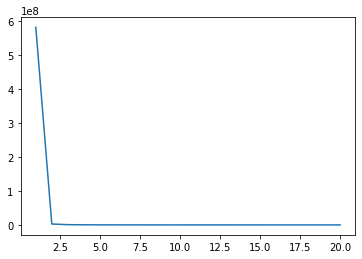

2


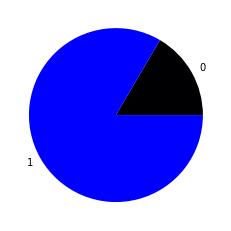

In [10]:
#Idea 1: K-Means clustering
#Problem is that it finds all pixels within a cluster but removes locality (ex. cluster contains two regions of green in
#different locations)
img1 = pics[0].astype('uint8')
img = cv2.cvtColor(img1, cv2.COLOR_BGR2HSV)
img=img.reshape((img.shape[1]*img.shape[0],3))

md=[]
for i in range(1,21): #TODO Tuning parameter
    kmeans=KMeans(n_clusters=i)
    kmeans.fit(img)
    o=kmeans.inertia_
    md.append(o)
print(md)

plt.plot(list(np.arange(1,21)),md) 
plt.show()
for i in range (0,len(md)):
    if md[i] < 2*md[i+1]: #TODO Tuning parameter
        nClusters = i-1
        break
print(nClusters)

kmeans=KMeans(n_clusters=nClusters)
s=kmeans.fit(img)
labels=kmeans.labels_
centroid=kmeans.cluster_centers_
labels=list(labels)
percent=[]
for i in range(len(centroid)):
    j=labels.count(i)
    j=j/(len(labels))
    percent.append(j)
plt.pie(percent,colors=np.array(centroid/255),labels=np.arange(len(centroid)))
plt.show()

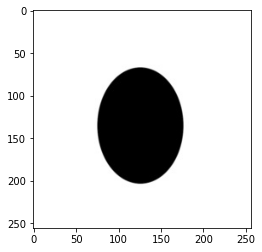

In [11]:
plt.imshow(img1[...,::-1])
plt.show()
pixLabels = np.array(labels).reshape((img1.shape[0],img1.shape[0]))
#for i in range(0,nClusters):
    #print(np.where(pixLabels == i))
    #pixLabels

## Custom color region detection method

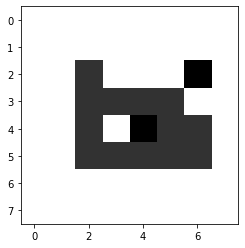

In [12]:
img1 = pics[-2].astype('uint8')
img1[2][2] = 50
#img1[2][3] = 50
#img1[2][4] = 0
#img1[2][5] = 0
img1[2][6] = 0
img1[3][2] = 50
img1[3][3] = 50
img1[3][4] = 50
img1[3][5] = 50
#img1[3][6] = 0
img1[4][2] = 50
#img1[4][3] = 0
img1[4][4] = 0
img1[4][5] = 50
img1[4][6] = 50
img1[5][2] = 50
img1[5][3] = 50
img1[5][4] = 50
img1[5][5] = 50
img1[5][6] = 50
plt.imshow(img1[...,::-1])
plt.show()

## Detect color regions and cluster

In [13]:
def checkFit(p1, p2):
    #print(np.rint(np.mean(p1[0])), p2[0])
    d=math.sqrt((np.rint(np.mean(p1[0])).astype(int)-p2[0])**2+
                            (np.rint(np.mean(p1[1])).astype(int)-p2[1])**2+
                            (np.rint(np.mean(p1[2])).astype(int)-p2[2])**2)
    p=d/math.sqrt((255)**2+(255)**2+(255)**2)
    return p

In [14]:
#Recursive function for each pixel that matches the cluster value, explore to see if it can get back to
#a visited pixel in the same cluster
#To allow diagonal escape, uncomment recursive lines
def findHome(startX, startY, i, j, img1, imgClusters, visited, clusterNum, cMean, finds):
    if i > img1.shape[0]-1 or i < 0 or j > img1.shape[0]-1 or j < 0:
        finds.append(1)
        return
    searched[i][j] = 0
    if (i == startX and j == startY) or (visited[i][j] == 0 and (checkFit(cMean, img1[i][j]) <= thresh)):
        finds.append(2)
        return
    if visited[i][j] != 0 and (checkFit(cMean, img1[i][j]) > thresh):
        finds.append(3)
        return
    if visited[i][j] != 0 and (checkFit(cMean, img1[i][j]) <= thresh):
        finds.append(4)
        #if not (i-1 > img1.shape[0]-1 or i-1 < 0 or j-1 > img1.shape[0]-1 or j-1 < 0):
        #    if searched[i-1][j-1] != 0:
                #findHome(startX, startY, i-1, j-1, img1, imgClusters, visited, clusterNum, cMean, finds)
        if not (i > img1.shape[0]-1 or i < 0 or j-1 > img1.shape[0]-1 or j-1 < 0):
            if searched[i][j-1] != 0:
                findHome(startX, startY, i, j-1, img1, imgClusters, visited, clusterNum, cMean, finds)
        #if not (i+1 > img1.shape[0]-1 or i+1 < 0 or j-1 > img1.shape[0]-1 or j-1 < 0):
        #    if searched[i+1][j-1] != 0:
                #findHome(startX, startY, i+1, j-1, img1, imgClusters, visited, clusterNum, cMean, finds)
        if not (i-1 > img1.shape[0]-1 or i-1 < 0 or j > img1.shape[0]-1 or j < 0):
            if searched[i-1][j] != 0:
                findHome(startX, startY, i-1, j, img1, imgClusters, visited, clusterNum, cMean, finds)
        if not (i+1 > img1.shape[0]-1 or i+1 < 0 or j > img1.shape[0]-1 or j < 0):
            if searched[i+1][j] != 0:
                findHome(startX, startY, i+1, j, img1, imgClusters, visited, clusterNum, cMean, finds)
        #if not (i-1 > img1.shape[0]-1 or i-1 < 0 or j+1 > img1.shape[0]-1 or j+1 < 0):
        #    if searched[i-1][j+1] != 0:
                #findHome(startX, startY, i-1, j+1, img1, imgClusters, visited, clusterNum, cMean, finds)
        if not (i > img1.shape[0]-1 or i < 0 or j+1 > img1.shape[0]-1 or j+1 < 0):
            if searched[i][j+1] != 0:
                findHome(startX, startY, i, j+1, img1, imgClusters, visited, clusterNum, cMean, finds)
        #if not (i+1 > img1.shape[0]-1 or i+1 < 0 or j+1 > img1.shape[0]-1 or j+1 < 0):
        #    if searched[i+1][j+1] != 0:
                #findHome(startX, startY, i+1, j+1, img1, imgClusters, visited, clusterNum, cMean, finds)
    return

In [15]:
#Idea 2: Keep track of average color within a region as I search for extent of a region and compare new pixel with average 
#rather than adjacent pixel and if it is added, adjust the average, if not draw boundary
#Make greedy assumption each iteration of a cluster that every remaining pixel is in that cluster until proven otherwise
#This is key for finding middle pixels
#img1 = pics[0].astype('uint8')
#def findImgClusters(img1, thresh=0.05, percentMerge=0.01):
    
img = cv2.cvtColor(img1, cv2.COLOR_BGR2HSV)

imgClusters = np.ones((img1.shape[0], img1.shape[1])).astype(int) #Matrix where each coord indicates its cluster (i,j) = cluster number
clusterEdges = [] #Clusters by perimeter matrix, gives the perimeter coordinates of every cluster
visited = np.ones((img1.shape[0], img1.shape[1])).astype(int) #Matrix if coord is 0, it has been added to a cluster, 1 has not gained membership
clusterNum = 1 #Current cluster number
clustMeans = []

thresh = 0.05
percentMerge = 0.01

#print(img, thresh, percentMerge)

while np.count_nonzero(visited) > 0:
    firstFind = 0
    #Set all unvisited pixels to current cluster value
    imgClusters[visited != 0] = clusterNum
    for i in range(0,img.shape[0]):
        for j in range(0,img.shape[1]):
            if visited[i][j] == 1:
                if firstFind == 0:
                    startX = i
                    startY = j
                    cMean = [[],[],[]] #Mean of the current cluster
                    clust = [] #Border pixels of current cluster
                    cMean[0].append(img[i][j][0])
                    cMean[1].append(img[i][j][1])
                    cMean[2].append(img[i][j][2])
                    firstFind = 1
                p = checkFit(cMean, img[i][j])

                #IF the current pixel is in the cluster
                if p < thresh: 
                    #Look for holes
                    reachable = False
                    searched = np.ones((img1.shape[0], img1.shape[1])).astype(int)
                    finds = []
                    findHome(startX, startY, i, j, img, imgClusters, visited, clusterNum, cMean, finds)
                    if (2 in finds or 1 in finds):
                        reachable = True
                    if reachable:
                        visited[i][j] = 0 #Mark it as visited
                        imgClusters[i][j] = clusterNum #Assign it to current cluster
                        cMean[0].append(img[i][j][0]) #Adjust the mean cluster value
                        cMean[1].append(img[i][j][1])
                        cMean[2].append(img[i][j][2])

                        #IF the current pixel is an absolute border pixel
                        if i+1 > img1.shape[0]-1 or i-1 < 0 or j+1 > img1.shape[0]-1 or j-1 < 0:
                            clust.append((i,j))

                        #IF the current pixel is not on the absolute border
                        else:
                            #IF any neighbors are in a different cluster, add current pixel to border
                            r1 = -1
                            r2 = -1
                            addPix = False
                            for m in range(0,3):
                                for n in range(0,3):
                                    if (checkFit(cMean, img[i+r1+m][j+r2+n]) > thresh):
                                        addPix = True
                            if addPix:
                                clust.append((i,j))

                #IF the current pixel is not in the cluster and not a border pixel, do nothing
                elif p >= thresh and (i+1 <= img1.shape[0]-1 or i-1 >= 0 or j+1 <= img1.shape[0]-1 or j-1 >= 0): 
                    r1 = -1
    clusterNum += 1
    clusterEdges.append(list(set(clust)))
    clustMeans.append((np.rint(np.mean(cMean[0])).astype(int), np.rint(np.mean(cMean[1])).astype(int), np.rint(np.mean(cMean[2])).astype(int)))
#TODO TODO Go back through and anything that is a single point as a cluster joins adjacent cluster
#If percent of a cluster is under a certain amount of the total, merge it with a close one
#return imgClusters

In [17]:
imgClusters

array([[1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 2, 1, 1, 1, 3, 1],
       [1, 1, 2, 2, 2, 2, 1, 1],
       [1, 1, 2, 4, 5, 2, 2, 1],
       [1, 1, 2, 2, 2, 2, 2, 1],
       [1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1]])

## Sort the clusters

In [36]:
def sortClusters(visited, edgesSorted, x, y):
    curX = 0
    curY = 0
    inertia = -1
    hops = 0
    
    #find min coord, prioritizes min y first then x
    unvisited = [j for j in range(len(visited[i])) if visited[i][j] == 0]
    availMin = [clusterEdges[i][j] for j in unvisited]
    if len(availMin) < 1:
        return edgesSorted
    curX = min(availMin)[0]
    curY = min(availMin)[1]
    homeX = curX
    homeY = curY
    curIndex = clusterEdges[i].index((curX, curY))
    
    #add to outer, mark visited
    edgesSorted[i][0].append(curX)
    edgesSorted[i][1].append(curY)
    visited[i][curIndex] = 1
    
    if (curX+1, curY) in clusterEdges[i] and visited[i][clusterEdges[i].index((curX+1, curY))] != 1:
        inertia = 1
    elif (curX, curY+1) in clusterEdges[i] and visited[i][clusterEdges[i].index((curX, curY+1))] != 1:
        inertia = 2
    elif (curX-1, curY) in clusterEdges[i] and visited[i][clusterEdges[i].index((curX-1, curY))] != 1:
        inertia = 3
    elif (curX, curY-1) in clusterEdges[i] and visited[i][clusterEdges[i].index((curX, curY-1))] != 1:
        inertia = 4
        
    #curX, curY, homeX, homeY, curIndex, inertia
    while (visited[i].count(0) > 0) and (not ((curX+1 == homeX and curY == homeY) or (curX-1 == homeX and curY == homeY) or 
                                         (curX == homeX and curY+1 == homeY) or (curX == homeX and curY-1 == homeY)) and 
                                         inertia != -1 or hops < 2):
        #print("Starting position:", (curX, curY), '\nStarting inertia:', inertia)
        
        down = (curX+1, curY) in clusterEdges[i]
        right = (curX, curY+1) in clusterEdges[i]
        up = (curX-1, curY) in clusterEdges[i]
        left = (curX, curY-1) in clusterEdges[i]
                
        skippable = False
        #if theres only one option
        if not down and not right and not up:
            inertia = 4
            skippable = True
        if not right and not up and not left:
            inertia = 1
            skippable = True
        if not up and not left and not down:
            inertia = 2
            skippable = True
        if not left and not down and not right:
            inertia = 3
            skippable = True
        
        #if going in direction and can keep going in direction with unvisited
        if inertia == 1 and down and visited[i][clusterEdges[i].index((curX+1, curY))] != 1:
            skippable = True
        elif inertia == 2 and right and visited[i][clusterEdges[i].index((curX, curY+1))] != 1:
            skippable = True
        elif inertia == 3 and up and visited[i][clusterEdges[i].index((curX-1, curY))] != 1:
            skippable = True
        elif inertia == 4 and left and visited[i][clusterEdges[i].index((curX, curY-1))] != 1:
            skippable = True
        
        if not skippable:
            moveable = False
            possibleDirs = []
            if down:
                #print("dir 1 to ", (curX+1, curY))
                possibleDirs.append(1)
                if visited[i][clusterEdges[i].index((curX+1, curY))] != 1:
                    inertia = 1
                    moveable = True
            if right:
                #print("dir 2 to ", (curX, curY+1))
                possibleDirs.append(2)
                if visited[i][clusterEdges[i].index((curX, curY+1))] != 1:
                    inertia = 2
                    moveable = True
            if up:
                #print("dir 3 to ", (curX-1, curY))
                possibleDirs.append(3)
                if visited[i][clusterEdges[i].index((curX-1, curY))] != 1:
                    inertia = 3
                    moveable = True
            if left:
                #print("dir 4 to ", (curX, curY-1))
                possibleDirs.append(4)
                if visited[i][clusterEdges[i].index((curX, curY-1))] != 1:
                    inertia = 4
                    moveable = True
            #print("Middle inertia:", inertia, "\nMiddle Moveable:",moveable)
            #continue inertia if possible
            if not moveable:
                #all neighbors visited but inertia is possible wait
                if inertia not in possibleDirs:
                    #all neighbors visited but inertia not possible
                    unvisited = [j for j in range(len(visited[i])) if visited[i][j] == 0]
                    availMin = [clusterEdges[i][j] for j in unvisited]
                    oneCount = sum(j[0] > curX for j in availMin)
                    twoCount = sum(j[1] > curY for j in availMin)
                    threeCount = sum(j[0] < curX for j in availMin)
                    fourCount = sum(j[1] < curY for j in availMin)
                    #print(availMin, '\n', oneCount, twoCount, threeCount, fourCount)
                    #find available direction with most unvisited and move that way
                    #if theres a tie, it prioritizes min y then x, make it have tendency to not retrace unless necessary
                    l = [oneCount,twoCount,threeCount,fourCount]
                    m = [i+1 for i, x in enumerate(l) if x == max(l)]
                    wrongDir = 0
                    if inertia+2 in m:
                        wrongDir = (m.index(inertia+2)+3)
                    elif inertia-2 in m:
                        wrongDir = (m.index(inertia-2)+1)
                    inertia = [x for x in m if wrongDir != x][0]
                    #inertia = np.argmax([oneCount, twoCount, threeCount, fourCount])+1
        if inertia == 1:
            curX+=1
        elif inertia == 2:
            curY+=1
        elif inertia == 3:
            curX-=1
        elif inertia == 4:
            curY-=1
        #print("Ending Position:", (curX, curY), '\nEnding Inertia:', inertia, "\n")
        if not ((visited[i].count(0) > 0) and (not ((curX+1 == homeX and curY == homeY) or (curX-1 == homeX and curY == homeY) or 
                                         (curX == homeX and curY+1 == homeY) or (curX == homeX and curY-1 == homeY)) and 
                                         inertia != -1 or hops < 2)):
            return edgesSorted
        curIndex = clusterEdges[i].index((curX, curY))
        edgesSorted[i][x].append(curX)
        edgesSorted[i][y].append(curY)
        visited[i][curIndex] = 1
        hops += 1
    return edgesSorted

In [37]:
#Search through image clusters and move in same direction until not possible then move in other direction to form trace
edgesSorted = [None]*len(clusterEdges)
for i in range(0,len(edgesSorted)):
    edgesSorted[i] = [[],[],[],[]]
visited = copy.deepcopy(clusterEdges)
for i in range (0,len(visited)):
    for j in range (0, len(visited[i])):
        visited[i][j] = 0

#Visited, edgesSorted, clusterEdges
for i in range(0, len(clusterEdges)):
    #Outer
    edgesSorted = sortClusters(visited, edgesSorted, 0, 1)
    #Inner
    edgesSorted = sortClusters(visited, edgesSorted, 2, 3)

## Segment sorted clusters into piecewise polynomials

In [299]:
#clustMeans, edgesSorted
f = open("imComp.txt", "a")
for i in range(0,len(edgesSorted)):
    print("C" + str(i) + ';' + str(clustMeans[i][0]) + ',' + str(clustMeans[i][1]) + ',' + str(clustMeans[i][2]))
    l = [[],[]]
    vert = [[],[]]
    track = -1
    for j in range(0,len(edgesSorted[0]), 2):
        for k in range(0, len(edgesSorted[i][j])):
            x = edgesSorted[i][j][k]
            y = edgesSorted[i][j+1][k]
            if (k+1 == len(edgesSorted[i][j])):
                saveX = edgesSorted[i][j][k]
                saveY = edgesSorted[i][j+1][k]
            if x not in l[0]:
                if track == 1:
                    print("V:" + str(vert[0][0]) + ',' + str(vert[1][0]) + ',' + str(vert[0][-1]) + ',' + str(vert[1][-1]))
                    #f.write(str(vert[0]) + ',' + str(vert[-1]) + ',' clustMeans[i] + '\n')
                vert = [[],[]]
                track = 0
            else:
                if track == 0:
                    coefs = polyFit(l[0], l[1])
                    print("P:" + str(l[0][0]) + ',' + str(l[1][0]) + ';' + "POLY" + ';' + str(l[0][-1]) + ',' + str(l[1][-1]))
                l = [[],[]]
                track = 1
            vert[0].append(x)
            vert[1].append(y)
            l[0].append(x)
            l[1].append(y)
    print("E:" + str(saveX) + ',' + str(saveY) + '\n')
f.close()

C0;0,0,255
Res: 1.0
1.0
P:0,0;POLY;7,0
V:7,0,7,7
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
P:7,7;POLY;0,7
V:0,7,0,1
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
P:0,1;POLY;6,1
V:6,1,6,7
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
P:6,7;POLY;3,7
V:3,7,3,7
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0


<ipython-input-299-8cd76392e642>:23: RankWarning: Polyfit may be poorly conditioned
  coefs = polyFit(l[0], l[1])
<ipython-input-299-8cd76392e642>:23: RankWarning: Polyfit may be poorly conditioned
  coefs = polyFit(l[0], l[1])
<ipython-input-299-8cd76392e642>:23: RankWarning: Polyfit may be poorly conditioned
  coefs = polyFit(l[0], l[1])
<ipython-input-299-8cd76392e642>:23: RankWarning: Polyfit may be poorly conditioned
  coefs = polyFit(l[0], l[1])
<ipython-input-299-8cd76392e642>:23: RankWarning: Polyfit may be poorly conditioned
  coefs = polyFit(l[0], l[1])
<ipython-input-299-8cd76392e642>:23: RankWarning: Polyfit may be poorly conditioned
  coefs = polyFit(l[0], l[1])
<ipython-input-299-8cd76392e642>:23: RankWarning: Polyfit may be poorly conditioned
  coefs = polyFit(l[0], l[1])
<ipython-input-299-8cd76392e642>:23: RankWarning: Polyfit may be poorly conditioned
  coefs = polyFit(l[0], l[1])
<ipython-input-299-8cd76392e642>:23: RankWarning: Polyfit may be poorly conditioned
  co

Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
P:3,7;POLY;1,7
V:1,7,1,5
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
P:1,5;POLY;2,5
V:2,5,2,3
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
P:2,3;POLY;1,3
E:1,2

C1;0,0,50
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 

<ipython-input-299-8cd76392e642>:23: RankWarning: Polyfit may be poorly conditioned
  coefs = polyFit(l[0], l[1])
<ipython-input-299-8cd76392e642>:23: RankWarning: Polyfit may be poorly conditioned
  coefs = polyFit(l[0], l[1])
<ipython-input-299-8cd76392e642>:23: RankWarning: Polyfit may be poorly conditioned
  coefs = polyFit(l[0], l[1])
<ipython-input-299-8cd76392e642>:23: RankWarning: Polyfit may be poorly conditioned
  coefs = polyFit(l[0], l[1])
<ipython-input-299-8cd76392e642>:23: RankWarning: Polyfit may be poorly conditioned
  coefs = polyFit(l[0], l[1])
<ipython-input-299-8cd76392e642>:23: RankWarning: Polyfit may be poorly conditioned
  coefs = polyFit(l[0], l[1])
<ipython-input-299-8cd76392e642>:23: RankWarning: Polyfit may be poorly conditioned
  coefs = polyFit(l[0], l[1])
<ipython-input-299-8cd76392e642>:23: RankWarning: Polyfit may be poorly conditioned
  coefs = polyFit(l[0], l[1])
<ipython-input-299-8cd76392e642>:23: RankWarning: Polyfit may be poorly conditioned
  co

0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
P:2,2;POLY;5,2
V:5,2,5,6
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
P:5,6;POLY;4,6
V:4,6,4,5
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
Res: 0.0
P:4,5;POLY;3,5
E:3,3

C2;0,0,0
E:2,6

C3;0,0,255
E:4,3

C4;0,0,0
E:4,4



<ipython-input-299-8cd76392e642>:23: RankWarning: Polyfit may be poorly conditioned
  coefs = polyFit(l[0], l[1])
<ipython-input-299-8cd76392e642>:23: RankWarning: Polyfit may be poorly conditioned
  coefs = polyFit(l[0], l[1])
<ipython-input-299-8cd76392e642>:23: RankWarning: Polyfit may be poorly conditioned
  coefs = polyFit(l[0], l[1])
<ipython-input-299-8cd76392e642>:23: RankWarning: Polyfit may be poorly conditioned
  coefs = polyFit(l[0], l[1])
<ipython-input-299-8cd76392e642>:23: RankWarning: Polyfit may be poorly conditioned
  coefs = polyFit(l[0], l[1])
<ipython-input-299-8cd76392e642>:23: RankWarning: Polyfit may be poorly conditioned
  coefs = polyFit(l[0], l[1])
<ipython-input-299-8cd76392e642>:23: RankWarning: Polyfit may be poorly conditioned
  coefs = polyFit(l[0], l[1])
<ipython-input-299-8cd76392e642>:23: RankWarning: Polyfit may be poorly conditioned
  coefs = polyFit(l[0], l[1])
<ipython-input-299-8cd76392e642>:23: RankWarning: Polyfit may be poorly conditioned
  co

In [298]:
#Fit to polynomial
def polyFit(x,y):
    y = np.array(y)
    x = np.array(x)
    for i in range(0,21):
        pol = np.poly1d(np.polyfit(x, y, 5))
        test = pol(x).astype(int)
        print("Res:", r2_score(y, pol(x)))
        if r2_score(y, pol(x)) > 0.9:
            print(r2_score(y, pol(x)))
            return

## Save equations to file, compression complete